In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns
import shap

In [2]:
DATA_PATH="/home/rakibul/WORK/RESEARCH/Speech_Recognition/MAIN STUDY/GitHub Repo/Vowel_Data/Formant/"

In [3]:
seed=42

In [4]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
#             length=len(individual_formant)
#             F_i=individual_formant.loc[2:,'F1':'F5'].values
#             F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
#             F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
#             assert len(F_i)==len(F_i1)==len(F_i2)
            #individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=np.abs(F_i-2*F_i1+F_i2)
            
            #individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        #folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        #folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        #folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        #folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [21]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 435.34it/s]


In [22]:
np.random.seed(seed)

In [23]:
model_v=Sequential()
model_v.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(128, activation='tanh'))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [24]:
model_v.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 119       
Total params: 28,263
Trainable params: 28,263
Non-trainable params: 0
__________________________________________________

In [25]:
X_train.shape[1]

5

In [26]:
model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    #metrics=['AUC']#,
    metrics=[['accuracy','AUC']]
)

In [27]:
history_v=model_v.fit(X_train, y_train_hot, epochs=700, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/700
1/1 [==============================] - 0s 325ms/step - loss: 1.9948 - accuracy: 0.0834 - auc: 0.4682 - val_loss: 1.6836 - val_accuracy: 0.3996 - val_auc: 0.7491
Epoch 2/700
1/1 [==============================] - 0s 81ms/step - loss: 1.6830 - accuracy: 0.3958 - auc: 0.7498 - val_loss: 1.5825 - val_accuracy: 0.4310 - val_auc: 0.7859
Epoch 3/700
1/1 [==============================] - 0s 71ms/step - loss: 1.5809 - accuracy: 0.4317 - auc: 0.7864 - val_loss: 1.5164 - val_accuracy: 0.4663 - val_auc: 0.8102
Epoch 4/700
1/1 [==============================] - 0s 79ms/step - loss: 1.5138 - accuracy: 0.4752 - auc: 0.8111 - val_loss: 1.4641 - val_accuracy: 0.4794 - val_auc: 0.8332
Epoch 5/700
1/1 [==============================] - 0s 81ms/step - loss: 1.4609 - accuracy: 0.4864 - auc: 0.8345 - val_loss: 1.4201 - val_accuracy: 0.4952 - val_auc: 0.8499
Epoch 6/700
1/1 [==============================] - 0s 72ms/step - loss: 1.4174 - accuracy: 0.4965 - auc: 0.8511 - val_loss: 1.3789 - val_ac

1/1 [==============================] - 0s 87ms/step - loss: 0.7596 - accuracy: 0.7166 - auc: 0.9542 - val_loss: 0.7504 - val_accuracy: 0.7271 - val_auc: 0.9548
Epoch 49/700
1/1 [==============================] - 0s 69ms/step - loss: 0.7547 - accuracy: 0.7190 - auc: 0.9547 - val_loss: 0.7461 - val_accuracy: 0.7247 - val_auc: 0.9553
Epoch 50/700
1/1 [==============================] - 0s 66ms/step - loss: 0.7496 - accuracy: 0.7175 - auc: 0.9553 - val_loss: 0.7417 - val_accuracy: 0.7282 - val_auc: 0.9557
Epoch 51/700
1/1 [==============================] - 0s 67ms/step - loss: 0.7446 - accuracy: 0.7193 - auc: 0.9557 - val_loss: 0.7375 - val_accuracy: 0.7254 - val_auc: 0.9563
Epoch 52/700
1/1 [==============================] - 0s 73ms/step - loss: 0.7397 - accuracy: 0.7199 - auc: 0.9563 - val_loss: 0.7328 - val_accuracy: 0.7388 - val_auc: 0.9566
Epoch 53/700
1/1 [==============================] - 0s 74ms/step - loss: 0.7349 - accuracy: 0.7276 - auc: 0.9567 - val_loss: 0.7286 - val_accuracy: 

1/1 [==============================] - 0s 73ms/step - loss: 0.5566 - accuracy: 0.8033 - auc: 0.9744 - val_loss: 0.5532 - val_accuracy: 0.8147 - val_auc: 0.9744
Epoch 96/700
1/1 [==============================] - 0s 70ms/step - loss: 0.5515 - accuracy: 0.8077 - auc: 0.9748 - val_loss: 0.5473 - val_accuracy: 0.8164 - val_auc: 0.9749
Epoch 97/700
1/1 [==============================] - 0s 65ms/step - loss: 0.5444 - accuracy: 0.8106 - auc: 0.9755 - val_loss: 0.5444 - val_accuracy: 0.8175 - val_auc: 0.9750
Epoch 98/700
1/1 [==============================] - 0s 84ms/step - loss: 0.5416 - accuracy: 0.8099 - auc: 0.9758 - val_loss: 0.5432 - val_accuracy: 0.8179 - val_auc: 0.9753
Epoch 99/700
1/1 [==============================] - 0s 75ms/step - loss: 0.5407 - accuracy: 0.8131 - auc: 0.9758 - val_loss: 0.5392 - val_accuracy: 0.8193 - val_auc: 0.9753
Epoch 100/700
1/1 [==============================] - 0s 73ms/step - loss: 0.5362 - accuracy: 0.8120 - auc: 0.9762 - val_loss: 0.5323 - val_accuracy:

1/1 [==============================] - 0s 73ms/step - loss: 0.4146 - accuracy: 0.8581 - auc: 0.9852 - val_loss: 0.4355 - val_accuracy: 0.8556 - val_auc: 0.9828
Epoch 143/700
1/1 [==============================] - 0s 82ms/step - loss: 0.4133 - accuracy: 0.8605 - auc: 0.9853 - val_loss: 0.4333 - val_accuracy: 0.8581 - val_auc: 0.9830
Epoch 144/700
1/1 [==============================] - 0s 71ms/step - loss: 0.4112 - accuracy: 0.8593 - auc: 0.9855 - val_loss: 0.4321 - val_accuracy: 0.8574 - val_auc: 0.9829
Epoch 145/700
1/1 [==============================] - 0s 73ms/step - loss: 0.4087 - accuracy: 0.8619 - auc: 0.9856 - val_loss: 0.4301 - val_accuracy: 0.8567 - val_auc: 0.9831
Epoch 146/700
1/1 [==============================] - 0s 71ms/step - loss: 0.4064 - accuracy: 0.8606 - auc: 0.9858 - val_loss: 0.4296 - val_accuracy: 0.8570 - val_auc: 0.9831
Epoch 147/700
1/1 [==============================] - 0s 80ms/step - loss: 0.4059 - accuracy: 0.8627 - auc: 0.9858 - val_loss: 0.4333 - val_accur

1/1 [==============================] - 0s 74ms/step - loss: 0.3459 - accuracy: 0.8778 - auc: 0.9892 - val_loss: 0.3885 - val_accuracy: 0.8708 - val_auc: 0.9858
Epoch 190/700
1/1 [==============================] - 0s 79ms/step - loss: 0.3436 - accuracy: 0.8786 - auc: 0.9893 - val_loss: 0.3818 - val_accuracy: 0.8733 - val_auc: 0.9860
Epoch 191/700
1/1 [==============================] - 0s 74ms/step - loss: 0.3348 - accuracy: 0.8821 - auc: 0.9900 - val_loss: 0.3874 - val_accuracy: 0.8705 - val_auc: 0.9857
Epoch 192/700
1/1 [==============================] - 0s 71ms/step - loss: 0.3381 - accuracy: 0.8817 - auc: 0.9897 - val_loss: 0.3803 - val_accuracy: 0.8765 - val_auc: 0.9859
Epoch 193/700
1/1 [==============================] - 0s 65ms/step - loss: 0.3322 - accuracy: 0.8830 - auc: 0.9900 - val_loss: 0.3770 - val_accuracy: 0.8736 - val_auc: 0.9864
Epoch 194/700
1/1 [==============================] - 0s 68ms/step - loss: 0.3299 - accuracy: 0.8828 - auc: 0.9902 - val_loss: 0.3775 - val_accur

1/1 [==============================] - 0s 70ms/step - loss: 0.2641 - accuracy: 0.9097 - auc: 0.9937 - val_loss: 0.3380 - val_accuracy: 0.8863 - val_auc: 0.9886
Epoch 237/700
1/1 [==============================] - 0s 79ms/step - loss: 0.2627 - accuracy: 0.9111 - auc: 0.9938 - val_loss: 0.3355 - val_accuracy: 0.8860 - val_auc: 0.9887
Epoch 238/700
1/1 [==============================] - 0s 67ms/step - loss: 0.2604 - accuracy: 0.9117 - auc: 0.9939 - val_loss: 0.3359 - val_accuracy: 0.8881 - val_auc: 0.9888
Epoch 239/700
1/1 [==============================] - 0s 77ms/step - loss: 0.2590 - accuracy: 0.9110 - auc: 0.9939 - val_loss: 0.3348 - val_accuracy: 0.8881 - val_auc: 0.9887
Epoch 240/700
1/1 [==============================] - 0s 71ms/step - loss: 0.2582 - accuracy: 0.9135 - auc: 0.9939 - val_loss: 0.3351 - val_accuracy: 0.8878 - val_auc: 0.9890
Epoch 241/700
1/1 [==============================] - 0s 85ms/step - loss: 0.2573 - accuracy: 0.9134 - auc: 0.9940 - val_loss: 0.3351 - val_accur

1/1 [==============================] - 0s 66ms/step - loss: 0.2155 - accuracy: 0.9312 - auc: 0.9956 - val_loss: 0.3271 - val_accuracy: 0.8930 - val_auc: 0.9895
Epoch 284/700
1/1 [==============================] - 0s 72ms/step - loss: 0.2156 - accuracy: 0.9308 - auc: 0.9954 - val_loss: 0.3270 - val_accuracy: 0.8913 - val_auc: 0.9893
Epoch 285/700
1/1 [==============================] - 0s 72ms/step - loss: 0.2122 - accuracy: 0.9331 - auc: 0.9956 - val_loss: 0.3287 - val_accuracy: 0.8870 - val_auc: 0.9889
Epoch 286/700
1/1 [==============================] - 0s 66ms/step - loss: 0.2137 - accuracy: 0.9311 - auc: 0.9956 - val_loss: 0.3238 - val_accuracy: 0.8902 - val_auc: 0.9896
Epoch 287/700
1/1 [==============================] - 0s 76ms/step - loss: 0.2095 - accuracy: 0.9342 - auc: 0.9957 - val_loss: 0.3269 - val_accuracy: 0.8952 - val_auc: 0.9891
Epoch 288/700
1/1 [==============================] - 0s 81ms/step - loss: 0.2109 - accuracy: 0.9324 - auc: 0.9956 - val_loss: 0.3268 - val_accur

1/1 [==============================] - 0s 75ms/step - loss: 0.1710 - accuracy: 0.9506 - auc: 0.9969 - val_loss: 0.3231 - val_accuracy: 0.8948 - val_auc: 0.9889
Epoch 331/700
1/1 [==============================] - 0s 74ms/step - loss: 0.1701 - accuracy: 0.9499 - auc: 0.9969 - val_loss: 0.3246 - val_accuracy: 0.8941 - val_auc: 0.9887
Epoch 332/700
1/1 [==============================] - 0s 71ms/step - loss: 0.1690 - accuracy: 0.9521 - auc: 0.9969 - val_loss: 0.3234 - val_accuracy: 0.8969 - val_auc: 0.9891
Epoch 333/700
1/1 [==============================] - 0s 75ms/step - loss: 0.1676 - accuracy: 0.9507 - auc: 0.9970 - val_loss: 0.3241 - val_accuracy: 0.8952 - val_auc: 0.9888
Epoch 334/700
1/1 [==============================] - 0s 77ms/step - loss: 0.1667 - accuracy: 0.9519 - auc: 0.9970 - val_loss: 0.3234 - val_accuracy: 0.8983 - val_auc: 0.9890
Epoch 335/700
1/1 [==============================] - 0s 74ms/step - loss: 0.1661 - accuracy: 0.9515 - auc: 0.9970 - val_loss: 0.3249 - val_accur

1/1 [==============================] - 0s 67ms/step - loss: 0.1406 - accuracy: 0.9595 - auc: 0.9976 - val_loss: 0.3276 - val_accuracy: 0.9026 - val_auc: 0.9872
Epoch 378/700
1/1 [==============================] - 0s 68ms/step - loss: 0.1374 - accuracy: 0.9590 - auc: 0.9977 - val_loss: 0.3298 - val_accuracy: 0.8983 - val_auc: 0.9872
Epoch 379/700
1/1 [==============================] - 0s 64ms/step - loss: 0.1376 - accuracy: 0.9592 - auc: 0.9977 - val_loss: 0.3342 - val_accuracy: 0.9005 - val_auc: 0.9875
Epoch 380/700
1/1 [==============================] - 0s 65ms/step - loss: 0.1388 - accuracy: 0.9597 - auc: 0.9977 - val_loss: 0.3307 - val_accuracy: 0.9012 - val_auc: 0.9872
Epoch 381/700
1/1 [==============================] - 0s 78ms/step - loss: 0.1382 - accuracy: 0.9590 - auc: 0.9978 - val_loss: 0.3328 - val_accuracy: 0.8998 - val_auc: 0.9874
Epoch 382/700
1/1 [==============================] - 0s 71ms/step - loss: 0.1360 - accuracy: 0.9604 - auc: 0.9978 - val_loss: 0.3296 - val_accur

1/1 [==============================] - 0s 78ms/step - loss: 0.1123 - accuracy: 0.9687 - auc: 0.9983 - val_loss: 0.3375 - val_accuracy: 0.9019 - val_auc: 0.9861
Epoch 425/700
1/1 [==============================] - 0s 67ms/step - loss: 0.1100 - accuracy: 0.9715 - auc: 0.9983 - val_loss: 0.3383 - val_accuracy: 0.9012 - val_auc: 0.9860
Epoch 426/700
1/1 [==============================] - 0s 72ms/step - loss: 0.1085 - accuracy: 0.9718 - auc: 0.9983 - val_loss: 0.3359 - val_accuracy: 0.9033 - val_auc: 0.9861
Epoch 427/700
1/1 [==============================] - 0s 67ms/step - loss: 0.1078 - accuracy: 0.9715 - auc: 0.9984 - val_loss: 0.3380 - val_accuracy: 0.9022 - val_auc: 0.9861
Epoch 428/700
1/1 [==============================] - 0s 78ms/step - loss: 0.1078 - accuracy: 0.9718 - auc: 0.9984 - val_loss: 0.3373 - val_accuracy: 0.9050 - val_auc: 0.9859
Epoch 429/700
1/1 [==============================] - 0s 88ms/step - loss: 0.1077 - accuracy: 0.9710 - auc: 0.9984 - val_loss: 0.3397 - val_accur

1/1 [==============================] - 0s 78ms/step - loss: 0.0897 - accuracy: 0.9765 - auc: 0.9988 - val_loss: 0.3456 - val_accuracy: 0.9075 - val_auc: 0.9852
Epoch 472/700
1/1 [==============================] - 0s 77ms/step - loss: 0.0887 - accuracy: 0.9776 - auc: 0.9988 - val_loss: 0.3476 - val_accuracy: 0.9072 - val_auc: 0.9844
Epoch 473/700
1/1 [==============================] - 0s 64ms/step - loss: 0.0883 - accuracy: 0.9775 - auc: 0.9988 - val_loss: 0.3494 - val_accuracy: 0.9047 - val_auc: 0.9842
Epoch 474/700
1/1 [==============================] - 0s 74ms/step - loss: 0.0880 - accuracy: 0.9777 - auc: 0.9988 - val_loss: 0.3474 - val_accuracy: 0.9075 - val_auc: 0.9846
Epoch 475/700
1/1 [==============================] - 0s 71ms/step - loss: 0.0871 - accuracy: 0.9769 - auc: 0.9988 - val_loss: 0.3486 - val_accuracy: 0.9058 - val_auc: 0.9849
Epoch 476/700
1/1 [==============================] - 0s 71ms/step - loss: 0.0872 - accuracy: 0.9782 - auc: 0.9988 - val_loss: 0.3514 - val_accur

1/1 [==============================] - 0s 68ms/step - loss: 0.0732 - accuracy: 0.9826 - auc: 0.9991 - val_loss: 0.3667 - val_accuracy: 0.9058 - val_auc: 0.9827
Epoch 519/700
1/1 [==============================] - 0s 130ms/step - loss: 0.0718 - accuracy: 0.9841 - auc: 0.9992 - val_loss: 0.3664 - val_accuracy: 0.9058 - val_auc: 0.9827
Epoch 520/700
1/1 [==============================] - 0s 71ms/step - loss: 0.0713 - accuracy: 0.9837 - auc: 0.9992 - val_loss: 0.3661 - val_accuracy: 0.9075 - val_auc: 0.9826
Epoch 521/700
1/1 [==============================] - 0s 66ms/step - loss: 0.0696 - accuracy: 0.9855 - auc: 0.9992 - val_loss: 0.3657 - val_accuracy: 0.9082 - val_auc: 0.9825
Epoch 522/700
1/1 [==============================] - 0s 62ms/step - loss: 0.0690 - accuracy: 0.9852 - auc: 0.9992 - val_loss: 0.3673 - val_accuracy: 0.9068 - val_auc: 0.9827
Epoch 523/700
1/1 [==============================] - 0s 63ms/step - loss: 0.0691 - accuracy: 0.9845 - auc: 0.9992 - val_loss: 0.3690 - val_accu

1/1 [==============================] - 0s 66ms/step - loss: 0.0578 - accuracy: 0.9874 - auc: 0.9994 - val_loss: 0.3880 - val_accuracy: 0.9079 - val_auc: 0.9810
Epoch 566/700
1/1 [==============================] - 0s 106ms/step - loss: 0.0572 - accuracy: 0.9890 - auc: 0.9994 - val_loss: 0.3875 - val_accuracy: 0.9089 - val_auc: 0.9809
Epoch 567/700
1/1 [==============================] - 0s 80ms/step - loss: 0.0565 - accuracy: 0.9884 - auc: 0.9995 - val_loss: 0.3883 - val_accuracy: 0.9072 - val_auc: 0.9808
Epoch 568/700
1/1 [==============================] - 0s 67ms/step - loss: 0.0560 - accuracy: 0.9889 - auc: 0.9994 - val_loss: 0.3891 - val_accuracy: 0.9079 - val_auc: 0.9809
Epoch 569/700
1/1 [==============================] - 0s 108ms/step - loss: 0.0557 - accuracy: 0.9894 - auc: 0.9995 - val_loss: 0.3894 - val_accuracy: 0.9086 - val_auc: 0.9805
Epoch 570/700
1/1 [==============================] - 0s 103ms/step - loss: 0.0557 - accuracy: 0.9886 - auc: 0.9995 - val_loss: 0.3907 - val_ac

1/1 [==============================] - 0s 65ms/step - loss: 0.0469 - accuracy: 0.9905 - auc: 0.9996 - val_loss: 0.4113 - val_accuracy: 0.9096 - val_auc: 0.9798
Epoch 613/700
1/1 [==============================] - 0s 70ms/step - loss: 0.0472 - accuracy: 0.9902 - auc: 0.9995 - val_loss: 0.4098 - val_accuracy: 0.9107 - val_auc: 0.9794
Epoch 614/700
1/1 [==============================] - 0s 74ms/step - loss: 0.0468 - accuracy: 0.9903 - auc: 0.9996 - val_loss: 0.4116 - val_accuracy: 0.9093 - val_auc: 0.9800
Epoch 615/700
1/1 [==============================] - 0s 70ms/step - loss: 0.0469 - accuracy: 0.9901 - auc: 0.9995 - val_loss: 0.4115 - val_accuracy: 0.9103 - val_auc: 0.9792
Epoch 616/700
1/1 [==============================] - 0s 68ms/step - loss: 0.0464 - accuracy: 0.9907 - auc: 0.9996 - val_loss: 0.4125 - val_accuracy: 0.9114 - val_auc: 0.9799
Epoch 617/700
1/1 [==============================] - 0s 74ms/step - loss: 0.0466 - accuracy: 0.9901 - auc: 0.9995 - val_loss: 0.4137 - val_accur

1/1 [==============================] - 0s 91ms/step - loss: 0.0502 - accuracy: 0.9874 - auc: 0.9997 - val_loss: 0.4172 - val_accuracy: 0.9050 - val_auc: 0.9794
Epoch 660/700
1/1 [==============================] - 0s 66ms/step - loss: 0.0501 - accuracy: 0.9882 - auc: 0.9996 - val_loss: 0.4170 - val_accuracy: 0.9068 - val_auc: 0.9797
Epoch 661/700
1/1 [==============================] - 0s 69ms/step - loss: 0.0482 - accuracy: 0.9891 - auc: 0.9997 - val_loss: 0.4189 - val_accuracy: 0.9050 - val_auc: 0.9801
Epoch 662/700
1/1 [==============================] - 0s 83ms/step - loss: 0.0480 - accuracy: 0.9894 - auc: 0.9997 - val_loss: 0.4201 - val_accuracy: 0.9054 - val_auc: 0.9799
Epoch 663/700
1/1 [==============================] - 0s 74ms/step - loss: 0.0478 - accuracy: 0.9891 - auc: 0.9996 - val_loss: 0.4187 - val_accuracy: 0.9043 - val_auc: 0.9799
Epoch 664/700
1/1 [==============================] - 0s 74ms/step - loss: 0.0464 - accuracy: 0.9894 - auc: 0.9996 - val_loss: 0.4160 - val_accur

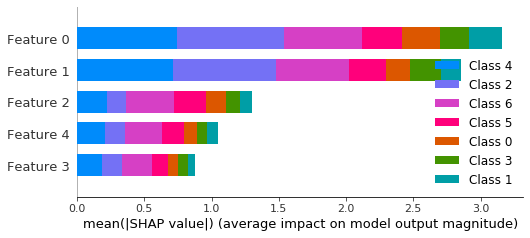

In [11]:
# e=shap.DeepExplainer(model_v,X_test)
# shape_values=e.shap_values(X_test)
# shap.summary_plot(shape_values,X_test)

In [28]:
history_dict_v=history_v.history

loss_v=history_dict_v['loss']
val_loss_v=history_dict_v['val_loss']

acc_v=history_dict_v['accuracy']
val_acc_v=history_dict_v['val_accuracy']

auc_v=history_dict_v['auc']
val_auc_v=history_dict_v['val_auc']

In [29]:
epochs=range(1,len(loss_v)+1)
ticks=[1]
ticks2=[i for i in range(30,len(loss_v)+1,30)] #for 300 epochs
ticks2=[i for i in range(50,len(loss_v)+1,50)] #for 700 epochs
ticks.extend(ticks2)

In [30]:
save_specifier='5F_HL5_tanh_adam_005_batchfull_seed42_epochs_700'

[<matplotlib.lines.Line2D at 0x7f95c00809d0>]

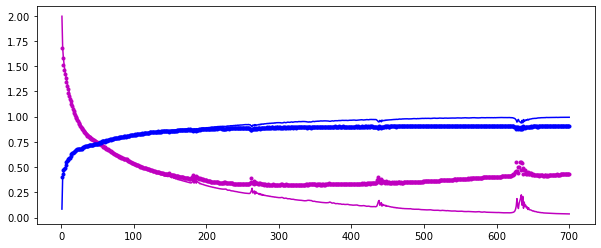

In [31]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'m', label='Training Loss')
plt.plot(epochs,val_loss_v,'m.', label='Validation Loss')

plt.plot(epochs,acc_v,'b', label='Training ACC')
plt.plot(epochs,val_acc_v,'b.', label='Validation ACC')

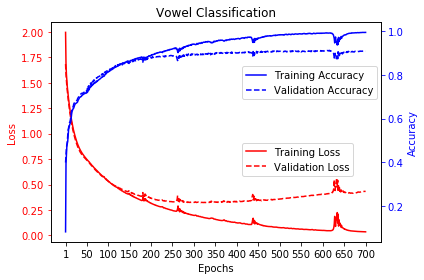

In [40]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'r', label='Training Loss')
ln2=ax.plot(epochs,val_loss_v,'r--', label='Validation Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs,auc_v,'r', label='Training AUC')
#ln3=ax2.plot(epochs,val_auc_v,'o', label='Validation AUC')

ln3=ax2.plot(epochs,acc_v,'b', label='Training Accuracy')
ln3=ax2.plot(epochs,val_acc_v,'b--', label='Validation Accuracy')

ax.set_title('Vowel Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax2.set_ylabel('AUC - ROC')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks)
ax.legend(loc=(0.58,0.3))
ax2.legend(loc=(0.58,0.65))
#fig.legend(loc=(0.6,0.4))
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

plt.tight_layout()
plt.savefig('/home/rakibul/WORK/RESEARCH/Speech_Recognition/MAIN STUDY/GitHub Repo/Result/New_without_CNN/loss_acc_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [41]:
DATA_PATH="/home/rakibul/WORK/RESEARCH/Speech_Recognition/MAIN STUDY/GitHub Repo/Word_Data/Formant/"

In [42]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
#             length=len(individual_formant)
#             F_i=individual_formant.loc[2:,'F1':'F5'].values
#             F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
#             F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
#             assert len(F_i)==len(F_i1)==len(F_i2)
#             individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=np.abs(F_i-2*F_i1+F_i2)
            
#             individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        #folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        #folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        #folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        #folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [52]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 442.24it/s]


In [53]:
model_w=Sequential()
model_w.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
#model_w.add(Dropout(0.25))
model_w.add(Dense(128, activation='tanh'))
#model_w.add(Dropout(0.15))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [54]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    #metrics=['AUC']#,
    metrics=[['accuracy','AUC']]
)

In [55]:
history_w=model_w.fit(X_train, y_train_hot, epochs=700, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/700
1/1 [==============================] - 0s 319ms/step - loss: 1.9900 - accuracy: 0.1371 - auc: 0.4955 - val_loss: 1.8584 - val_accuracy: 0.2958 - val_auc: 0.6418
Epoch 2/700
1/1 [==============================] - 0s 95ms/step - loss: 1.8515 - accuracy: 0.2987 - auc: 0.6462 - val_loss: 1.7578 - val_accuracy: 0.3235 - val_auc: 0.6985
Epoch 3/700
1/1 [==============================] - 0s 111ms/step - loss: 1.7538 - accuracy: 0.3306 - auc: 0.6997 - val_loss: 1.7319 - val_accuracy: 0.3258 - val_auc: 0.7122
Epoch 4/700
1/1 [==============================] - 0s 130ms/step - loss: 1.7247 - accuracy: 0.3333 - auc: 0.7147 - val_loss: 1.7054 - val_accuracy: 0.3342 - val_auc: 0.7242
Epoch 5/700
1/1 [==============================] - 0s 86ms/step - loss: 1.6957 - accuracy: 0.3424 - auc: 0.7287 - val_loss: 1.6856 - val_accuracy: 0.3466 - val_auc: 0.7329
Epoch 6/700
1/1 [==============================] - 0s 89ms/step - loss: 1.6750 - accuracy: 0.3499 - auc: 0.7375 - val_loss: 1.6715 - val_

1/1 [==============================] - 0s 103ms/step - loss: 1.4417 - accuracy: 0.4553 - auc: 0.8172 - val_loss: 1.4643 - val_accuracy: 0.4378 - val_auc: 0.8092
Epoch 49/700
1/1 [==============================] - 0s 80ms/step - loss: 1.4340 - accuracy: 0.4592 - auc: 0.8194 - val_loss: 1.4568 - val_accuracy: 0.4446 - val_auc: 0.8115
Epoch 50/700
1/1 [==============================] - 0s 87ms/step - loss: 1.4263 - accuracy: 0.4638 - auc: 0.8216 - val_loss: 1.4495 - val_accuracy: 0.4477 - val_auc: 0.8136
Epoch 51/700
1/1 [==============================] - 0s 110ms/step - loss: 1.4185 - accuracy: 0.4676 - auc: 0.8239 - val_loss: 1.4426 - val_accuracy: 0.4479 - val_auc: 0.8157
Epoch 52/700
1/1 [==============================] - 0s 82ms/step - loss: 1.4108 - accuracy: 0.4685 - auc: 0.8260 - val_loss: 1.4357 - val_accuracy: 0.4510 - val_auc: 0.8178
Epoch 53/700
1/1 [==============================] - 0s 89ms/step - loss: 1.4033 - accuracy: 0.4703 - auc: 0.8283 - val_loss: 1.4288 - val_accuracy

1/1 [==============================] - 0s 89ms/step - loss: 1.1901 - accuracy: 0.5607 - auc: 0.8789 - val_loss: 1.2506 - val_accuracy: 0.5368 - val_auc: 0.8649
Epoch 96/700
1/1 [==============================] - 0s 102ms/step - loss: 1.1870 - accuracy: 0.5610 - auc: 0.8794 - val_loss: 1.2471 - val_accuracy: 0.5320 - val_auc: 0.8659
Epoch 97/700
1/1 [==============================] - 0s 86ms/step - loss: 1.1834 - accuracy: 0.5635 - auc: 0.8804 - val_loss: 1.2455 - val_accuracy: 0.5376 - val_auc: 0.8662
Epoch 98/700
1/1 [==============================] - 0s 101ms/step - loss: 1.1793 - accuracy: 0.5640 - auc: 0.8811 - val_loss: 1.2418 - val_accuracy: 0.5361 - val_auc: 0.8671
Epoch 99/700
1/1 [==============================] - 0s 82ms/step - loss: 1.1752 - accuracy: 0.5680 - auc: 0.8821 - val_loss: 1.2399 - val_accuracy: 0.5383 - val_auc: 0.8675
Epoch 100/700
1/1 [==============================] - 0s 90ms/step - loss: 1.1716 - accuracy: 0.5686 - auc: 0.8828 - val_loss: 1.2384 - val_accurac

1/1 [==============================] - 0s 103ms/step - loss: 1.0472 - accuracy: 0.6183 - auc: 0.9077 - val_loss: 1.1682 - val_accuracy: 0.5736 - val_auc: 0.8835
Epoch 143/700
1/1 [==============================] - 0s 84ms/step - loss: 1.0491 - accuracy: 0.6162 - auc: 0.9069 - val_loss: 1.1751 - val_accuracy: 0.5693 - val_auc: 0.8822
Epoch 144/700
1/1 [==============================] - 0s 82ms/step - loss: 1.0495 - accuracy: 0.6174 - auc: 0.9072 - val_loss: 1.1635 - val_accuracy: 0.5708 - val_auc: 0.8845
Epoch 145/700
1/1 [==============================] - 0s 79ms/step - loss: 1.0414 - accuracy: 0.6202 - auc: 0.9084 - val_loss: 1.1590 - val_accuracy: 0.5802 - val_auc: 0.8852
Epoch 146/700
1/1 [==============================] - 0s 84ms/step - loss: 1.0336 - accuracy: 0.6231 - auc: 0.9099 - val_loss: 1.1641 - val_accuracy: 0.5752 - val_auc: 0.8844
Epoch 147/700
1/1 [==============================] - 0s 106ms/step - loss: 1.0354 - accuracy: 0.6247 - auc: 0.9097 - val_loss: 1.1587 - val_acc

1/1 [==============================] - 0s 85ms/step - loss: 0.9342 - accuracy: 0.6650 - auc: 0.9268 - val_loss: 1.1140 - val_accuracy: 0.6001 - val_auc: 0.8956
Epoch 190/700
1/1 [==============================] - 0s 95ms/step - loss: 0.9333 - accuracy: 0.6658 - auc: 0.9269 - val_loss: 1.1114 - val_accuracy: 0.5952 - val_auc: 0.8959
Epoch 191/700
1/1 [==============================] - 0s 85ms/step - loss: 0.9318 - accuracy: 0.6654 - auc: 0.9271 - val_loss: 1.1109 - val_accuracy: 0.5995 - val_auc: 0.8961
Epoch 192/700
1/1 [==============================] - 0s 87ms/step - loss: 0.9280 - accuracy: 0.6678 - auc: 0.9278 - val_loss: 1.1097 - val_accuracy: 0.6013 - val_auc: 0.8965
Epoch 193/700
1/1 [==============================] - 0s 101ms/step - loss: 0.9264 - accuracy: 0.6669 - auc: 0.9280 - val_loss: 1.1097 - val_accuracy: 0.5973 - val_auc: 0.8963
Epoch 194/700
1/1 [==============================] - 0s 90ms/step - loss: 0.9250 - accuracy: 0.6689 - auc: 0.9283 - val_loss: 1.1074 - val_accu

1/1 [==============================] - 0s 91ms/step - loss: 0.8411 - accuracy: 0.7000 - auc: 0.9408 - val_loss: 1.0803 - val_accuracy: 0.6120 - val_auc: 0.9032
Epoch 237/700
1/1 [==============================] - 0s 113ms/step - loss: 0.8394 - accuracy: 0.7009 - auc: 0.9410 - val_loss: 1.0822 - val_accuracy: 0.6120 - val_auc: 0.9026
Epoch 238/700
1/1 [==============================] - 0s 92ms/step - loss: 0.8378 - accuracy: 0.7002 - auc: 0.9413 - val_loss: 1.0810 - val_accuracy: 0.6158 - val_auc: 0.9033
Epoch 239/700
1/1 [==============================] - 0s 100ms/step - loss: 0.8372 - accuracy: 0.6997 - auc: 0.9413 - val_loss: 1.0840 - val_accuracy: 0.6100 - val_auc: 0.9024
Epoch 240/700
1/1 [==============================] - 0s 90ms/step - loss: 0.8385 - accuracy: 0.7014 - auc: 0.9412 - val_loss: 1.0874 - val_accuracy: 0.6160 - val_auc: 0.9024
Epoch 241/700
1/1 [==============================] - 0s 80ms/step - loss: 0.8395 - accuracy: 0.6971 - auc: 0.9409 - val_loss: 1.0883 - val_acc

Epoch 283/700
1/1 [==============================] - 0s 108ms/step - loss: 0.7563 - accuracy: 0.7329 - auc: 0.9522 - val_loss: 1.0700 - val_accuracy: 0.6227 - val_auc: 0.9067
Epoch 284/700
1/1 [==============================] - 0s 99ms/step - loss: 0.7553 - accuracy: 0.7346 - auc: 0.9524 - val_loss: 1.0717 - val_accuracy: 0.6252 - val_auc: 0.9068
Epoch 285/700
1/1 [==============================] - 0s 91ms/step - loss: 0.7544 - accuracy: 0.7325 - auc: 0.9523 - val_loss: 1.0716 - val_accuracy: 0.6219 - val_auc: 0.9067
Epoch 286/700
1/1 [==============================] - 0s 114ms/step - loss: 0.7539 - accuracy: 0.7346 - auc: 0.9525 - val_loss: 1.0744 - val_accuracy: 0.6252 - val_auc: 0.9065
Epoch 287/700
1/1 [==============================] - 0s 93ms/step - loss: 0.7538 - accuracy: 0.7315 - auc: 0.9524 - val_loss: 1.0761 - val_accuracy: 0.6237 - val_auc: 0.9063
Epoch 288/700
1/1 [==============================] - 0s 96ms/step - loss: 0.7546 - accuracy: 0.7335 - auc: 0.9524 - val_loss: 1.

Epoch 330/700
1/1 [==============================] - 0s 100ms/step - loss: 0.6871 - accuracy: 0.7600 - auc: 0.9604 - val_loss: 1.0847 - val_accuracy: 0.6295 - val_auc: 0.9075
Epoch 331/700
1/1 [==============================] - 0s 84ms/step - loss: 0.6833 - accuracy: 0.7581 - auc: 0.9608 - val_loss: 1.0828 - val_accuracy: 0.6280 - val_auc: 0.9077
Epoch 332/700
1/1 [==============================] - 0s 99ms/step - loss: 0.6820 - accuracy: 0.7595 - auc: 0.9610 - val_loss: 1.0832 - val_accuracy: 0.6290 - val_auc: 0.9078
Epoch 333/700
1/1 [==============================] - 0s 79ms/step - loss: 0.6823 - accuracy: 0.7594 - auc: 0.9609 - val_loss: 1.0888 - val_accuracy: 0.6287 - val_auc: 0.9073
Epoch 334/700
1/1 [==============================] - 0s 97ms/step - loss: 0.6816 - accuracy: 0.7590 - auc: 0.9610 - val_loss: 1.0818 - val_accuracy: 0.6285 - val_auc: 0.9083
Epoch 335/700
1/1 [==============================] - 0s 91ms/step - loss: 0.6772 - accuracy: 0.7632 - auc: 0.9615 - val_loss: 1.0

1/1 [==============================] - 0s 85ms/step - loss: 0.6218 - accuracy: 0.7844 - auc: 0.9675 - val_loss: 1.1091 - val_accuracy: 0.6277 - val_auc: 0.9076
Epoch 378/700
1/1 [==============================] - 0s 81ms/step - loss: 0.6203 - accuracy: 0.7832 - auc: 0.9675 - val_loss: 1.1024 - val_accuracy: 0.6320 - val_auc: 0.9083
Epoch 379/700
1/1 [==============================] - 0s 87ms/step - loss: 0.6179 - accuracy: 0.7857 - auc: 0.9678 - val_loss: 1.1094 - val_accuracy: 0.6308 - val_auc: 0.9074
Epoch 380/700
1/1 [==============================] - 0s 86ms/step - loss: 0.6165 - accuracy: 0.7860 - auc: 0.9679 - val_loss: 1.1056 - val_accuracy: 0.6331 - val_auc: 0.9081
Epoch 381/700
1/1 [==============================] - 0s 82ms/step - loss: 0.6166 - accuracy: 0.7860 - auc: 0.9679 - val_loss: 1.1133 - val_accuracy: 0.6318 - val_auc: 0.9069
Epoch 382/700
1/1 [==============================] - 0s 83ms/step - loss: 0.6164 - accuracy: 0.7858 - auc: 0.9679 - val_loss: 1.1085 - val_accur

1/1 [==============================] - 0s 86ms/step - loss: 0.5697 - accuracy: 0.8073 - auc: 0.9727 - val_loss: 1.1521 - val_accuracy: 0.6313 - val_auc: 0.9055
Epoch 425/700
1/1 [==============================] - 0s 79ms/step - loss: 0.5714 - accuracy: 0.8009 - auc: 0.9721 - val_loss: 1.1429 - val_accuracy: 0.6313 - val_auc: 0.9058
Epoch 426/700
1/1 [==============================] - 0s 84ms/step - loss: 0.5651 - accuracy: 0.8094 - auc: 0.9730 - val_loss: 1.1439 - val_accuracy: 0.6338 - val_auc: 0.9062
Epoch 427/700
1/1 [==============================] - 0s 82ms/step - loss: 0.5612 - accuracy: 0.8107 - auc: 0.9733 - val_loss: 1.1466 - val_accuracy: 0.6315 - val_auc: 0.9061
Epoch 428/700
1/1 [==============================] - 0s 84ms/step - loss: 0.5627 - accuracy: 0.8063 - auc: 0.9730 - val_loss: 1.1476 - val_accuracy: 0.6285 - val_auc: 0.9059
Epoch 429/700
1/1 [==============================] - 0s 80ms/step - loss: 0.5617 - accuracy: 0.8105 - auc: 0.9733 - val_loss: 1.1450 - val_accur

1/1 [==============================] - 0s 80ms/step - loss: 0.5153 - accuracy: 0.8263 - auc: 0.9773 - val_loss: 1.1920 - val_accuracy: 0.6364 - val_auc: 0.9035
Epoch 472/700
1/1 [==============================] - 0s 82ms/step - loss: 0.5147 - accuracy: 0.8264 - auc: 0.9774 - val_loss: 1.1855 - val_accuracy: 0.6356 - val_auc: 0.9049
Epoch 473/700
1/1 [==============================] - 0s 79ms/step - loss: 0.5144 - accuracy: 0.8274 - auc: 0.9773 - val_loss: 1.1932 - val_accuracy: 0.6384 - val_auc: 0.9035
Epoch 474/700
1/1 [==============================] - 0s 95ms/step - loss: 0.5137 - accuracy: 0.8261 - auc: 0.9774 - val_loss: 1.1904 - val_accuracy: 0.6323 - val_auc: 0.9041
Epoch 475/700
1/1 [==============================] - 0s 86ms/step - loss: 0.5132 - accuracy: 0.8266 - auc: 0.9775 - val_loss: 1.1948 - val_accuracy: 0.6376 - val_auc: 0.9038
Epoch 476/700
1/1 [==============================] - 0s 86ms/step - loss: 0.5135 - accuracy: 0.8272 - auc: 0.9774 - val_loss: 1.1962 - val_accur

1/1 [==============================] - 0s 96ms/step - loss: 0.4772 - accuracy: 0.8407 - auc: 0.9804 - val_loss: 1.2407 - val_accuracy: 0.6318 - val_auc: 0.9015
Epoch 519/700
1/1 [==============================] - 0s 92ms/step - loss: 0.4730 - accuracy: 0.8432 - auc: 0.9808 - val_loss: 1.2357 - val_accuracy: 0.6379 - val_auc: 0.9025
Epoch 520/700
1/1 [==============================] - 0s 83ms/step - loss: 0.4716 - accuracy: 0.8419 - auc: 0.9808 - val_loss: 1.2414 - val_accuracy: 0.6338 - val_auc: 0.9021
Epoch 521/700
1/1 [==============================] - 0s 82ms/step - loss: 0.4708 - accuracy: 0.8453 - auc: 0.9810 - val_loss: 1.2374 - val_accuracy: 0.6361 - val_auc: 0.9019
Epoch 522/700
1/1 [==============================] - 0s 83ms/step - loss: 0.4708 - accuracy: 0.8427 - auc: 0.9809 - val_loss: 1.2442 - val_accuracy: 0.6379 - val_auc: 0.9021
Epoch 523/700
1/1 [==============================] - 0s 89ms/step - loss: 0.4698 - accuracy: 0.8451 - auc: 0.9809 - val_loss: 1.2415 - val_accur

1/1 [==============================] - 0s 103ms/step - loss: 0.4334 - accuracy: 0.8581 - auc: 0.9838 - val_loss: 1.2845 - val_accuracy: 0.6394 - val_auc: 0.8999
Epoch 566/700
1/1 [==============================] - 0s 85ms/step - loss: 0.4291 - accuracy: 0.8595 - auc: 0.9841 - val_loss: 1.2895 - val_accuracy: 0.6412 - val_auc: 0.8996
Epoch 567/700
1/1 [==============================] - 0s 94ms/step - loss: 0.4295 - accuracy: 0.8602 - auc: 0.9840 - val_loss: 1.2917 - val_accuracy: 0.6399 - val_auc: 0.8989
Epoch 568/700
1/1 [==============================] - 0s 80ms/step - loss: 0.4324 - accuracy: 0.8584 - auc: 0.9838 - val_loss: 1.2990 - val_accuracy: 0.6397 - val_auc: 0.8989
Epoch 569/700
1/1 [==============================] - 0s 86ms/step - loss: 0.4330 - accuracy: 0.8586 - auc: 0.9837 - val_loss: 1.2933 - val_accuracy: 0.6409 - val_auc: 0.8990
Epoch 570/700
1/1 [==============================] - 0s 87ms/step - loss: 0.4331 - accuracy: 0.8573 - auc: 0.9838 - val_loss: 1.3056 - val_accu

1/1 [==============================] - 0s 84ms/step - loss: 0.4016 - accuracy: 0.8688 - auc: 0.9860 - val_loss: 1.3511 - val_accuracy: 0.6409 - val_auc: 0.8956
Epoch 613/700
1/1 [==============================] - 0s 90ms/step - loss: 0.3982 - accuracy: 0.8706 - auc: 0.9862 - val_loss: 1.3429 - val_accuracy: 0.6364 - val_auc: 0.8966
Epoch 614/700
1/1 [==============================] - 0s 93ms/step - loss: 0.3982 - accuracy: 0.8720 - auc: 0.9862 - val_loss: 1.3540 - val_accuracy: 0.6414 - val_auc: 0.8954
Epoch 615/700
1/1 [==============================] - 0s 106ms/step - loss: 0.3992 - accuracy: 0.8691 - auc: 0.9861 - val_loss: 1.3521 - val_accuracy: 0.6359 - val_auc: 0.8955
Epoch 616/700
1/1 [==============================] - 0s 98ms/step - loss: 0.3980 - accuracy: 0.8722 - auc: 0.9862 - val_loss: 1.3508 - val_accuracy: 0.6409 - val_auc: 0.8958
Epoch 617/700
1/1 [==============================] - 0s 96ms/step - loss: 0.3934 - accuracy: 0.8736 - auc: 0.9866 - val_loss: 1.3535 - val_accu

1/1 [==============================] - 0s 85ms/step - loss: 0.3842 - accuracy: 0.8742 - auc: 0.9868 - val_loss: 1.4117 - val_accuracy: 0.6333 - val_auc: 0.8920
Epoch 660/700
1/1 [==============================] - 0s 87ms/step - loss: 0.3755 - accuracy: 0.8775 - auc: 0.9877 - val_loss: 1.4164 - val_accuracy: 0.6404 - val_auc: 0.8915
Epoch 661/700
1/1 [==============================] - 0s 78ms/step - loss: 0.3827 - accuracy: 0.8723 - auc: 0.9872 - val_loss: 1.4064 - val_accuracy: 0.6412 - val_auc: 0.8931
Epoch 662/700
1/1 [==============================] - 0s 87ms/step - loss: 0.3754 - accuracy: 0.8757 - auc: 0.9875 - val_loss: 1.4171 - val_accuracy: 0.6379 - val_auc: 0.8917
Epoch 663/700
1/1 [==============================] - 0s 92ms/step - loss: 0.3732 - accuracy: 0.8779 - auc: 0.9877 - val_loss: 1.4181 - val_accuracy: 0.6376 - val_auc: 0.8919
Epoch 664/700
1/1 [==============================] - 0s 86ms/step - loss: 0.3719 - accuracy: 0.8798 - auc: 0.9879 - val_loss: 1.4132 - val_accur

In [56]:
history_dict_w=history_w.history
loss_w=history_dict_w['loss']
val_loss_w=history_dict_w['val_loss']

acc_w=history_dict_w['accuracy']
val_acc_w=history_dict_w['val_accuracy']

auc_w=history_dict_w['auc']
val_auc_w=history_dict_w['val_auc']

[<matplotlib.lines.Line2D at 0x7f960c067460>]

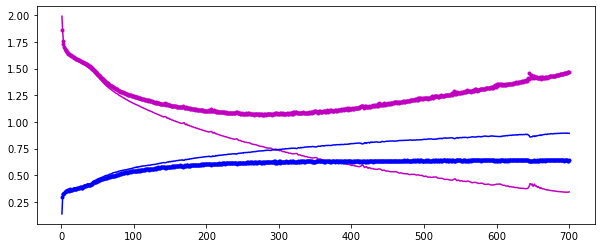

In [57]:
plt.figure(figsize=(10,4))
plt.plot(epochs_w,loss_w,'m', label='Training Loss')
plt.plot(epochs_w,val_loss_w,'m.', label='Validation Loss')

plt.plot(epochs_w,acc_w,'b', label='Training ACC')
plt.plot(epochs_w,val_acc_w,'b.', label='Validation ACC')

In [58]:
epochs_w=range(1,len(loss_w)+1)
ticks_w=[1]
# ticks2_w=[i for i in range(30,len(loss_w)+1,30)]
ticks2_w=[i for i in range(50,len(loss_w)+1,50)]
ticks_w.extend(ticks2_w)

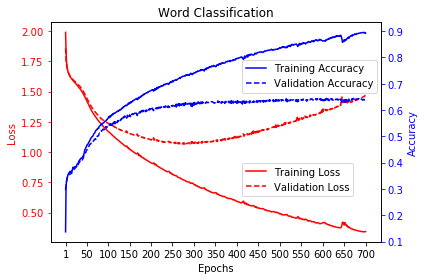

In [63]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs_w,loss_w,'r', label='Training Loss')
ln2=ax.plot(epochs_w,val_loss_w,'r--', label='Validation Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs_w,auc_w,'b', label='Training AUC')
#ln3=ax2.plot(epochs_w,val_auc_w,'b.', label='Validation AUC')

ln3=ax2.plot(epochs_w,acc_w,'b', label='Training Accuracy')
ln3=ax2.plot(epochs_w,val_acc_w,'b--', label='Validation Accuracy')

ax.set_title('Word Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax2.set_ylabel('AUC - ROC')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks_w)
ax.legend(loc=(0.58,0.21))
ax2.legend(loc=(0.58,0.68))
#fig.legend(loc=(0.6,0.4))
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

plt.tight_layout()
plt.savefig('/home/rakibul/WORK/RESEARCH/Speech_Recognition/MAIN STUDY/GitHub Repo/Result/New_without_CNN/loss_acc_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

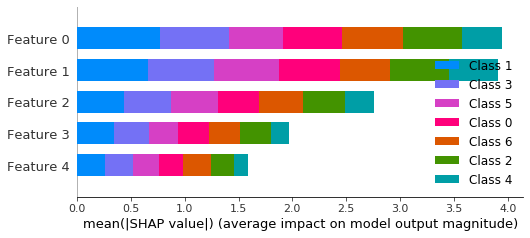

In [16]:
# e=shap.DeepExplainer(model_w,X_test)
# shape_values=e.shap_values(X_test)
# shap.summary_plot(shape_values,X_test)

In [42]:
#COMPARE

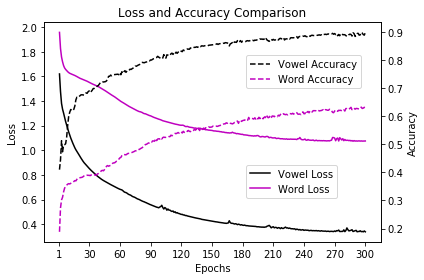

In [82]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,val_loss_v,'k', label='Vowel Loss')
ln2=ax.plot(epochs,val_loss_w,'m', label='Word Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs,val_auc_v,'b--', label='Vowel AUC')
#ln3=ax2.plot(epochs,val_auc_w,'r--', label='Word AUC')

ln3=ax2.plot(epochs,val_acc_v,'k--', label='Vowel Accuracy')
ln3=ax2.plot(epochs,val_acc_w,'m--', label='Word Accuracy')

ax.set_title('Loss and Accuracy Comparison')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))

plt.tight_layout()
plt.savefig('./New_without_CNN/comare_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [83]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')